<bn>

# 1. Introduction of sensorimotor experiment

![대체 텍스트](http://cfile215.uf.daum.net/image/994FA6475D4A71B004DC66)

### 1-1. Task paradigm 
- Participants conducted each of the four sensorimotor tasks including left-hand clenching (LH), right-hand clenching (RH), auditory attention (AD), and visual stimulus (VS) tasks (Jang et al., 2017; Kim et al., 2012).
  - LH / RH : clenched their left or right hand approximately twice per second
  - AD : listened to sounds of 1 kHz during the task period and 900 Hz during the rest period
  - VS : watched an alternating black and white checkerboard with 8 Hz during the task period and watched a black screen during the rest period
- A total of 360 fMRI volumes (i.e., 30 volumes/run × 4 runs/subject × 3 subjects) were available across all tasks and all subjects.



### 1-2. Blood-oxygenation-level-dependent (BOLD) fMRI data
- 3-T Tim Trio MRI scanner with a 12-channel head coil (Siemens, Erlangen, Germany)
- A standard gradient-echo echo-planar imaging pulse sequence
- TR/TE = 2000/30 ms; flip angle = 90°; in-plane voxels = 64 × 64; 36 axial slices; 4 mm slice thickness without a gap; voxel size = 3.75 × 3.75 × 4.0 mm^3) 



### 1-3. Preprocessing of BOLD fMRI data
- The fMRI volumes were preprocessed using the SPM8 software toolbox (www.fil.ion.ucl.ac.uk/spm) with standard options
  -  including slice timing correction, motion correction, spatial normalization to the Montreal Neurological Institute space with a 3-mm isotropic voxel size, and spatial smoothing using an 8-mm full-width at half-maximum Gaussian kernel.


  
  *Jang, H., Plis, S. M., Calhoun, V. D., & Lee, J. H. (2017). Task-specific feature extraction and classification of fMRI volumes using a deep neural network initialized with a deep belief network: Evaluation using sensorimotor tasks. Neuroimage, 145, 314-328.*
<bn><bn>
    
*Kim, Y. H., Kim, J., & Lee, J. H. (2012). Iterative approach of dual regression with a sparse prior enhances the performance of independent component analysis for group functional magnetic resonance imaging (fMRI) data. Neuroimage, 63(4), 1864-1889.*
<bn><bn>



---



# 2. Task classification using neural network (Tensorflow) 

## 2-0. Mounting Google drive to save the results 

In [1]:
# The directory in Google drive that you want to save the results at
gdrive_dir = '/KHBM2019_SummerSchool/Classification_of_fMRI_volume'

# Mounting your Google drive to the Google colab notebook 
from google.colab import drive
drive.mount('/content/drive')

import os

if not os.path.exists('/content/drive/My Drive'+gdrive_dir):
    os.makedirs('/content/drive/My Drive'+gdrive_dir)
os.chdir('/content/drive/My Drive'+gdrive_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 2-1. Input data

In [2]:
#!wget http://bspl.korea.ac.kr/sensorimotor.zip
#!unzip -j sensorimotor.zip

##################################################### or ##########################################################

if not os.path.exists('/content/drive/My Drive'+gdrive_dir+'/sensorimotor.zip'):
    !pip install pydrive
    print('\n\n')
    from pydrive.auth import GoogleAuth 
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    # Downloading the data from Google drive link 
    data_zip = drive.CreateFile({'id':'18sWmMHgHIN1eg069LfGlR20XEyB4mOZH'})
    data_zip.GetContentFile('sensorimotor.zip') 
    !unzip -j sensorimotor.zip

    print('\n ==> Succesfully downloaded and unzipped the data')
    
else: 
    print('\n ==> Data have already been downloaded')

### 1. You will have to choose google account of which it will be accessing google drive.                   ###
### 2. Copy the verification code and paste it into notebook. Press enter after pasting verification code.  ###
### ref) https://www.javacodemonk.com/guide-to-read-data-from-google-drive-in-google-colaboratory-079a3609  ###

     |████████████████████████████████| 993kB 3.4MB/s 
  Created wheel for pydrive: filename=PyDrive-1.3.1-cp36-none-any.whl size=27435 sha256=4e978187e02ea59147c062714280d29bac97d4df47549c15ad3ba86edffb1c7f
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive



Archive:  sensorimotor.zip
  inflating: sensorimotor_sbj1.nii   
  inflating: sensorimotor_sbj2.nii   
  inflating: sensorimotor_sbj3.nii   
  inflating: vMsk_3d.nii             
  inflating: y_sensorimotor_sbj1.mat  
  inflating: y_sensorimotor_sbj2.mat  
  inflating: y_sensorimotor_sbj3.mat  

 ==> Succesfully downloaded and unzipped the data


  
###  2-1-1. Percentage of BOLD signal
- The BOLD intensities of the fMRI volumes within a task-related period (i.e., three blocks of 20-s task periods after a 6-s delay from the task onset for each fMRI run) were normalized to percent signal change relative to the average BOLD signal with the 80-s baseline period.
- A total of 360 fMRI volumes (i.e., 30 volumes/run × 4 runs/subject × 3 subjects) were available across all tasks and all subjects  
<bn><bn>  

In [3]:
tasks=['LH','RH','AD','VIS']
n_tasks = len(tasks)
n_sbj = 3

# Installation of Nilearn to visualize nii file in Python
!pip install nilearn
from nilearn import image, plotting
print('\n\n')
from scipy import io as sio

# Load data
data_x = [None]*n_sbj
data_y = [None]*n_sbj
for sbj in range(n_sbj):
    data_x[sbj] = image.load_img('sensorimotor_sbj%d.nii'%(sbj+1))
    data_y[sbj] = sio.loadmat('y_sensorimotor_sbj%d.mat'%(sbj+1))['y'].squeeze()
    
print('\n ==> Data were opened')

     |████████████████████████████████| 2.4MB 3.4MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)






 ==> Data were opened


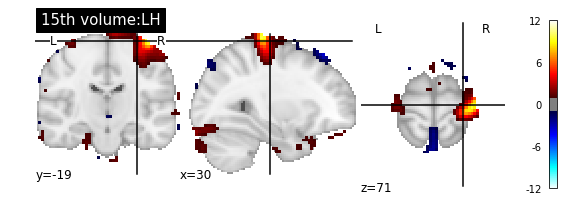

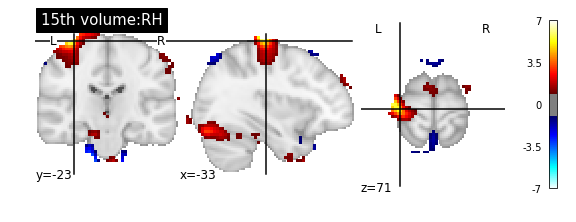

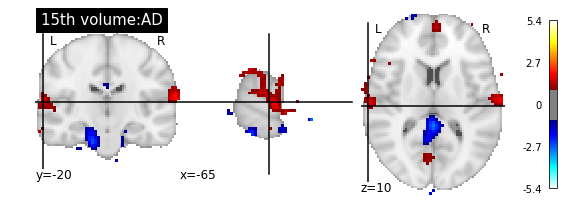

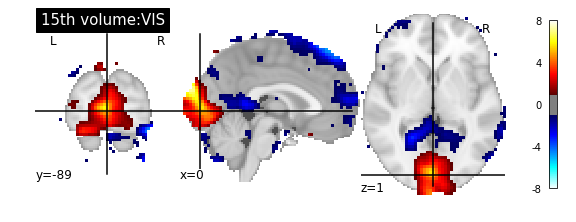

#################################################################### 
 


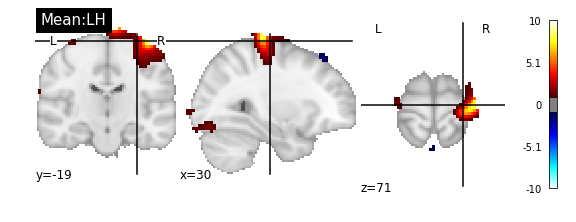

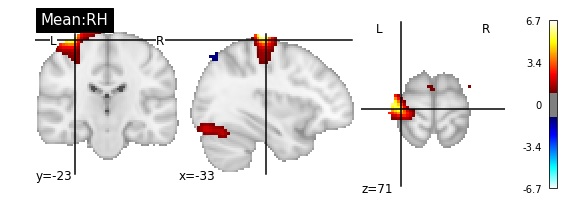

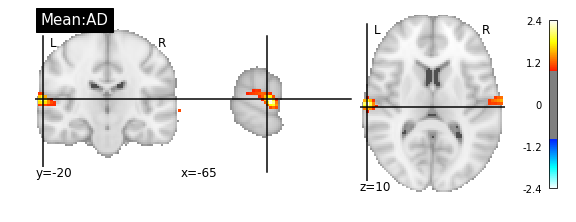

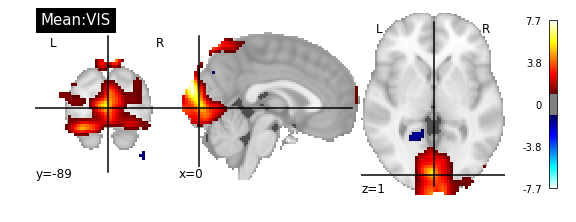

In [4]:
%matplotlib inline
import numpy as np

orth_cd = [[30,-19,71],[-33,-23,71],[-65,-20,10],[0,-89,1]]

# Get the dimension of data
[xdim, ydim, zdim, tdim] = data_x[sbj].shape
tdim_run = int(tdim/n_tasks)

# Examplary subject's 15th BOLD signal
for run in range(n_tasks):  
    image_plot = image.index_img(data_x[1], np.where(data_y[1]==run)[0]) 
    plotting.plot_stat_map(image.index_img(image_plot,14), threshold=1, title='15th volume:'+tasks[run], display_mode='ortho', cut_coords=orth_cd[run])
plotting.show();    
print('#################################################################### \n ')

# Examplary subject's average BOLD signal
for run in range(n_tasks):      
    image_plot = image.index_img(data_x[1], np.where(data_y[1]==run)[0]) 
    plotting.plot_stat_map(image.mean_img(image_plot), threshold=1, title='Mean:'+tasks[run], display_mode='ortho', cut_coords=orth_cd[run])
    
plotting.show(); 


### 2-1-2. In-brain mask  
- The voxels whose BOLD intensities were greater than 20% of the maximum BOLD intensity for each preprocessed fMRI volume were defined as an in-brain mask from the fMRI volume. 
- Then, the in-brain mask that overlapped across all fMRI volumes and all subjects was used to define the final set of input voxels, resulting in a total of 74,484 in-brain voxels


In [5]:
# Loead 3d mask and get the corresponding indices
vMsk_3d_nii = image.load_img('vMsk_3d.nii')
vMsk_3d = vMsk_3d_nii.get_data()
vMsk = np.where(vMsk_3d)

###########################################################################
# train_x  = 240 volumes x 74484 voxels
# train_y  = 240 volumes x 4 [one-hot vectors for each of LH, RH, AD and VS]
# test_x  = 120 volumes x 74484 voxels
# test_y  = 120 volumes x 4 [one-hot vectors for each of LH, RH, AD and VS]
###########################################################################

# 2 subjects' vectorized functional data
train_x = np.vstack([x.get_data()[vMsk][:].T for x in data_x[:-1]])
# One-hot encoding task labels
train_y = np.hstack([y for y in data_y[:-1]])
train_y = np.eye(n_tasks)[train_y]

# 1 subject's vectorized functional data
test_x = data_x[-1].get_data()[vMsk][:].T
# One-hot encoding task labels
test_y = data_y[-1].T
test_y = np.eye(n_tasks)[test_y]


sio.savemat("lhrhadvs_%dsbj.mat"%n_sbj, 
            mdict={'train_x':train_x, 'train_y':train_y, 'test_x': test_x,'test_y':test_y})

print('\n ==> Train & test samples were created')


 ==> Train & test samples were created


## 2-2. Import libraries

In [0]:
# -*- coding: utf-8 -*-

# This import statement gives Python access to all of TensorFlow's classes, methods, and symbols. 
import tensorflow as tf
# The fundamental package for scientific computing with Python.
import numpy as np
# Linear algebra module for calculating L1 and L2 norm  
from numpy import linalg as LA
# To plot the results
import matplotlib.pyplot as plt
%matplotlib inline
# To check the directory when saving the results
import os.path
# The module for file input and output
import scipy.io as sio
# To measure time
import timeit
# To get date information
from datetime import datetime
from pytz import timezone
# To get hsp combination
import itertools

## 2-3. Define a classifier

![대체 텍스트](http://cfile236.uf.daum.net/image/998625365D4BAA2430FF08)
(Jang et al., 2017)

In [0]:
"""
To create a multi-layer neural network (Multi-layer perceptron, MLP)   
"""

def init_model(n_nodes, layer_activation):
    
    if layer_activation=='sigmoid':
        layer_activation = tf.nn.sigmoid
    elif layer_activation=='tanh':
        layer_activation = tf.nn.tanh
    elif layer_activation=='relu':
        layer_activation = tf.nn.relu


    # 'node_index' to split placeholder, for example, given hidden_nodes=[100, 100, 100], nodes_index=[0, 100, 200, 300]
    nodes_index = [int(np.sum(n_nodes[1:i+1])) for i in range(np.size(n_nodes,axis=0)-1)]

    # Make two placeholders to fill the values later when training or testing
    X = tf.placeholder(tf.float32,[None,n_nodes[0]])
    Y = tf.placeholder(tf.float32,[None,n_nodes[-1]])

    # Create randomly initialized weight variables
    w_init = [tf.math.divide(tf.random_normal([n_nodes[i],n_nodes[i+1]]), tf.sqrt(float(n_nodes[i])/2)) for i in range(np.size(n_nodes,axis=0)-1)]
    w = [tf.Variable(w_init[i], dtype=tf.float32) for i in range(np.size(n_nodes,axis=0)-1)]
    # Create zero initialized bias variables
    b = [tf.Variable(tf.zeros([n_nodes[i+1]]), dtype=tf.float32) for i in range(np.size(n_nodes,axis=0)-1)]

    # Build an MLP model
    mlp_layers=[0.0]*(np.size(n_nodes,axis=0)-1)
    for i in range(np.size(n_nodes,axis=0)-1):
        # Input layer
        if i==0:
            mlp_layers[i] = tf.add(tf.matmul(X,w[i]),b[i])
            mlp_layers[i] = layer_activation(mlp_layers[i])
        # Hidden layers
        elif i>0 and i<(np.size(n_nodes,axis=0)-1):
            mlp_layers[i] = tf.add(tf.matmul(mlp_layers[i-1],w[i]),b[i])
            mlp_layers[i] = layer_activation(mlp_layers[i])
        # Output layer
        elif i==(np.size(n_nodes,axis=0)-1):
            mlp_layers[i] = tf.add(tf.matmul(mlp_layers[i-1],w[i]),b[i])


    return nodes_index, X, Y, mlp_layers, w, b

## 2-4. Define training parameters

In [0]:
"""
L1 and L2 regularization terms

""" 

def init_regularizations(mode, n_nodes, nodes_index, n_tg_hsp, w, b):

    if mode=='layer':
        # The size is same with the number of layers
        Beta = tf.placeholder(tf.float32,[n_tg_hsp])
        # Get L1 loss term by simply multiplying beta(scalar value) and L1 norm of weight for each layer
        L1_loss = [tf.reduce_sum(tf.multiply(tf.abs(w[i]),Beta[i])) for i in range(n_tg_hsp)]

    elif mode=='node':
        # The size is same with the number of nodes
        Beta = tf.placeholder(tf.float32,[np.sum(n_nodes[1:(n_tg_hsp+1)])])
        # Get L1 loss term by multiplying beta(vector values as many as n_nodes) and L1 norm of weight for each layer
        L1_loss = [tf.reduce_sum(tf.matmul(tf.abs(w[i]), tf.reshape(Beta[nodes_index[i]:nodes_index[i+1]],[-1,1]))) for i in range(n_tg_hsp)] 
        
    L1_loss_total = tf.reduce_sum(L1_loss)

    L2_REG = tf.placeholder(tf.float32)
    L2_loss = [tf.reduce_sum(tf.square(w[i])) for i in range(np.size(n_nodes,axis=0)-1)]
    L2_loss_total = tf.multiply(L2_REG,tf.reduce_sum(L2_loss))

    return Beta, L1_loss_total, L2_REG, L2_loss_total


""" 
Cost term (Cost = cross entropy + L1 term + L2 term ) 
"""
def init_cost(mlp_layers, Y, L1_loss_total, L2_loss_total):

    # A softmax regression : it adds up the evidence of our input being in certain classes, and converts that evidence into probabilities.
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=mlp_layers[-1], labels=Y)) \
                             + L1_loss_total + L2_loss_total

    return cost


""" 
Error term  
"""
def init_error(mlp_layers, Y):

    correct_prediction = tf.equal(tf.argmax(mlp_layers[-1],1),tf.argmax(Y,1))
    error = 1-tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

    
    return error


"""
TensorFlow provides optimizers that slowly change each variable in order to minimize the loss function.
"""
def init_optimizer(optimizer_algorithm, cost, momentum):
    
    Lr = tf.placeholder(tf.float32)
    
    if optimizer_algorithm=='GradientDescent':
        optimizer = tf.train.GradientDescentOptimizer(Lr).minimize(cost)
    elif optimizer_algorithm=='Adagrad':
        optimizer = tf.train.AdagradOptimizer(Lr).minimize(cost)
    elif optimizer_algorithm=='Adam':
        optimizer = tf.train.AdamOptimizer(Lr).minimize(cost)
    elif optimizer_algorithm=='Momentum':
        optimizer = tf.train.MomentumOptimizer(Lr,momentum).minimize(cost)
    elif optimizer_algorithm=='RMSProp':
        optimizer = tf.train.RMSPropOptimizer(Lr).minimize(cost)

    return Lr, optimizer



"""
Variables to store training results
"""
def init_savingVariables(mode, n_tg_hsp):
    if mode=='layer':
        beta_val = np.zeros(n_tg_hsp)
        beta_vec = np.zeros(n_tg_hsp)
        hsp_val = np.zeros(n_tg_hsp)
        result_beta = np.zeros(n_tg_hsp)
        result_hsp = np.zeros(n_tg_hsp)

    elif mode=='node':
        beta_val = [np.zeros(n_nodes[i+1]) for i in range(n_tg_hsp)]
        beta_vec = np.zeros(np.sum(n_nodes[1:-1]))
        hsp_val = [np.zeros(n_nodes[i+1]) for i in range(n_tg_hsp)]
        result_beta = [np.zeros(n_nodes[i+1]) for i in range(n_tg_hsp)]
        result_hsp = [np.zeros(n_nodes[i+1]) for i in range(n_tg_hsp)]


    # make arrays to store and plot results
    result_lr = np.zeros(1)
    result_cost = np.zeros(1)
    result_train_err = np.zeros(1)
    result_test_err = np.zeros(1)

    return beta_val, beta_vec, hsp_val, result_beta, result_hsp, result_lr, result_cost, result_train_err, result_test_err


## 2-5. Define Hoyer's sparsity control function

![대체 텍스트](http://cfile211.uf.daum.net/image/99936D3C5D4BA942271035)

In [0]:
"""
Weight sparisty control based in Hoyer's sparsity (hsp)
"""

def Hoyers_sparsity_control(mode, beta_lrates, W, b, max_b, tg):

    # Weight sparsity control with Hoyer's sparsness (Layer wise)
    if mode=='layer':

        # Get value of weight
        [n_nodes,dim]=W.shape
        num_elements=n_nodes*dim

        Wvec=W.flatten()

        # Calculate L1 and L2 norm
        L1=LA.norm(Wvec,1)
        L2=LA.norm(Wvec,2)

        # Calculate hoyer's sparsness
        h=(np.sqrt(num_elements)-(L1/L2))/(np.sqrt(num_elements)-1)

        # Update beta
        b-=beta_lrates*np.sign(h-tg)

        # Trim value
        b=0.0 if b<0.0 else b
        b=max_b if b>max_b else b

        return [h,b]

    # Weight sparsity control with Hoyer's sparsness (Node wise)
    elif mode=='node':

        b_vec = b

        # Get value of weight
        [n_nodes,dim]=W.shape

        # Calculate L1 and L2 norm
        L1=LA.norm(W,1,axis=0)
        L2=LA.norm(W,2,axis=0)

        h_vec = np.zeros((1,dim))
        tg_vec = np.ones(dim)*tg

        # Calculate hoyer's sparsness
        h_vec=(np.sqrt(n_nodes)-(L1/L2))/(np.sqrt(n_nodes)-1)

        # Update beta
        b_vec-=beta_lrates*np.sign(h_vec-tg_vec)

        # Trim value
        b_vec[b_vec<0.0]=0.0
        b_vec[b_vec>max_b]=max_b


        return [h_vec,b_vec]



## 2-6. Set hyperparameters for training

In [15]:
""" 
Set the number of nodes for input layer, hidden layers and output layer
"""
n_nodes=[74484,50,50,4]  # Do not forget to change beta max & beta lr components when changing the number of hidden layers


"""
Select the sparsity control mode
'layer' for a layer-wise sparsity control
'node' for a node-wise sparsity control
"""

mode = 'layer'

# Max beta
max_beta = [0.004, 0.11] 
# Beta learning rate
beta_lr = [0.0004, 0.011]

# Candidates of target sparsness level for each layer (0:dense~1:sparse)
hsp_cands = list(itertools.product([0.8, 0.4],[0.8, 0.4])) # [[0.8, 0.5, 0.5],[0.5, 0.5, 0.7]]
n_hsp_cands = len(hsp_cands)

print('\n ==> The candidate sparsity level sets : '+str(hsp_cands))


"""
Select optimizer :
    'GradientDescent'
    'Adagrad'
    'Adam'
    'Momentum'
    'RMSProp'
"""
optimizer_algorithm = 'Momentum'

momentum = 0.9


"""
Set learning hyperparameters
"""

# Total epochs
n_epochs = 200
# Mini batch size
batch_size = 50
# Initial learning rate
lr_init = 0.001
# Learning rate anealing after **th epoch
begin_anneal = 140
# Learning rate decay rate
decay_rate = 0.001
# Minimum learning rate
lr_min = 0.0002

# Layer activation 'sigmoid', 'tanh', 'relu'
layer_activation = 'relu'

# Lambda for L2 regularization
L2_reg = 1e-4


"""
Set the directory to save results
"""
directory_path = os.getcwd() 



 ==> The candidate sparsity level sets : [(0.8, 0.8), (0.8, 0.4), (0.4, 0.8), (0.4, 0.4)]


## 2-7. Initialize a model using definitions above

In [16]:
nodes_index, X, Y, mlp_layers, w, b = init_model(n_nodes, layer_activation)

Beta, L1_loss_total, L2_REG, L2_loss_total = init_regularizations(mode, n_nodes, nodes_index, len(hsp_cands[0]), w, b)
cost = init_cost(mlp_layers, Y, L1_loss_total, L2_loss_total)
error = init_error(mlp_layers, Y)

Lr, optimizer = init_optimizer(optimizer_algorithm, cost, momentum)


# Make a new results directory
dtime_utc = datetime.now(timezone('UTC'))
dtime = dtime_utc.astimezone(timezone('Asia/Seoul'))
directory_save = os.path.join(directory_path, r'results_%04d%02d%02d_%02d%02d'%(dtime.year,dtime.month,dtime.day,dtime.hour,dtime.minute))
if not os.path.exists(directory_save):
    os.makedirs(directory_save)

print('\n ==> The result directory path is '+directory_save)


 ==> The result directory path is /content/drive/My Drive/KHBM2019_SummerSchool/Classification_of_fMRI_volume/results_20190817_1014


## 2-8. Start learning


 ****************************** Validation phase *******************************

# ( 1 / 4 ) hsp candidate : (0.8, 0.8) #
< Epoch 50 > Cost : 27.2243 / Train err : 0.0250 /  Validation  err : 0.1583
             beta : [0.004 0.11 ] / hsp : [0.58019718 0.492475  ]
< Epoch 100 > Cost : 3.1140 / Train err : 0.0000 /  Validation  err : 0.1333
             beta : [0.   0.11] / hsp : [0.80212377 0.74707864]
< Epoch 150 > Cost : 0.0136 / Train err : 0.0000 /  Validation  err : 0.1333
             beta : [0.    0.011] / hsp : [0.80033049 0.79998102]
< Epoch 200 > Cost : 0.0717 / Train err : 0.0000 /  Validation  err : 0.1250
             beta : [0. 0.] / hsp : [0.80012681 0.80006319]



-> Accuracy : 0.875


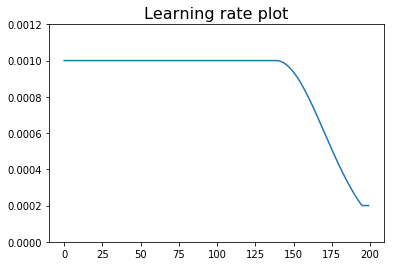

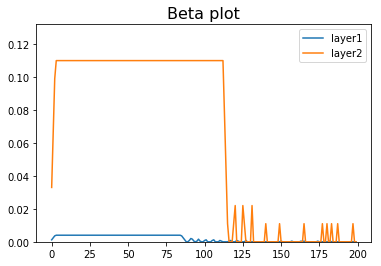

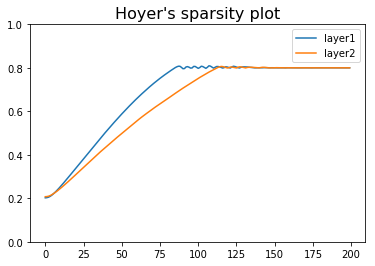

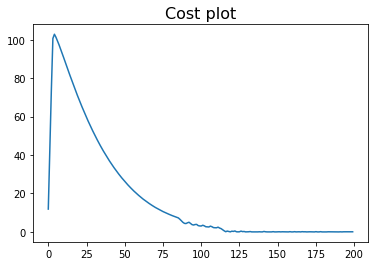

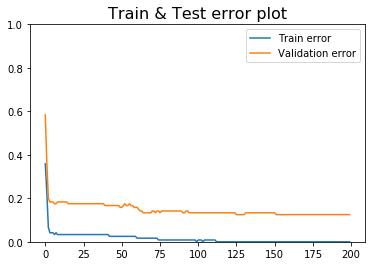


 ****************************** Validation phase *******************************

# ( 2 / 4 ) hsp candidate : (0.8, 0.4) #
< Epoch 50 > Cost : 12.4516 / Train err : 0.0000 /  Validation  err : 0.1333
             beta : [0.004 0.   ] / hsp : [0.58021588 0.42374739]
< Epoch 100 > Cost : 0.0114 / Train err : 0.0000 /  Validation  err : 0.1250
             beta : [0.0004 0.    ] / hsp : [0.79974077 0.4192053 ]
< Epoch 150 > Cost : 0.0056 / Train err : 0.0000 /  Validation  err : 0.1083
             beta : [0. 0.] / hsp : [0.80112232 0.41857357]
< Epoch 200 > Cost : 0.0052 / Train err : 0.0000 /  Validation  err : 0.1083
             beta : [0. 0.] / hsp : [0.80002106 0.41843115]



-> Accuracy : 0.892


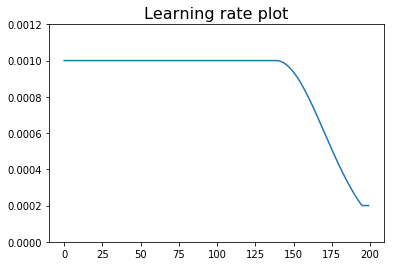

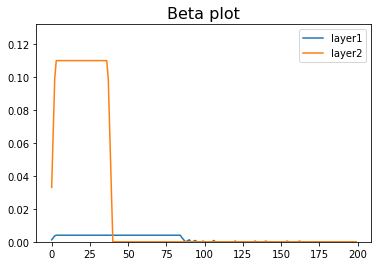

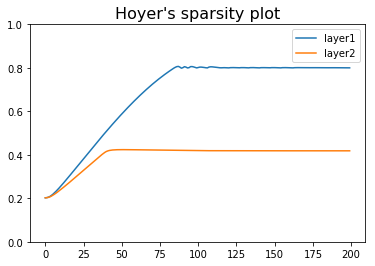

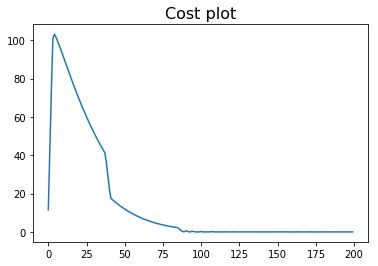

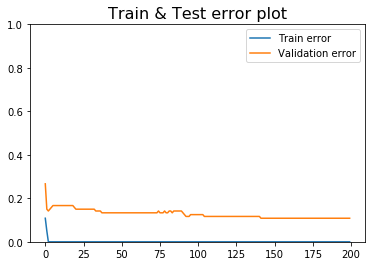


 ****************************** Validation phase *******************************

# ( 3 / 4 ) hsp candidate : (0.4, 0.8) #
< Epoch 50 > Cost : 14.5255 / Train err : 0.0250 /  Validation  err : 0.1583
             beta : [0.   0.11] / hsp : [0.43058332 0.49591107]
< Epoch 100 > Cost : 2.9425 / Train err : 0.0000 /  Validation  err : 0.1333
             beta : [0.   0.11] / hsp : [0.41938806 0.75087828]
< Epoch 150 > Cost : 0.0107 / Train err : 0.0000 /  Validation  err : 0.1333
             beta : [0. 0.] / hsp : [0.41162722 0.80092749]
< Epoch 200 > Cost : 0.0589 / Train err : 0.0000 /  Validation  err : 0.1250
             beta : [0. 0.] / hsp : [0.41070652 0.80009237]



-> Accuracy : 0.875


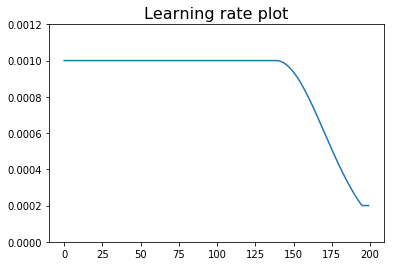

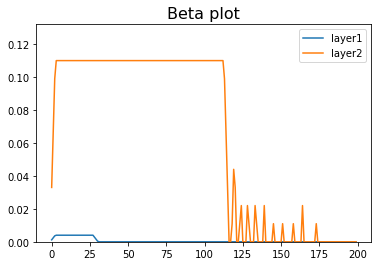

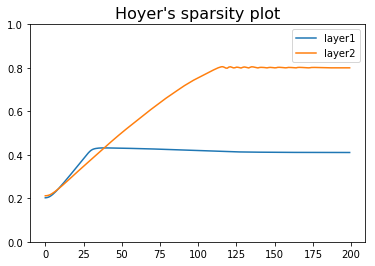

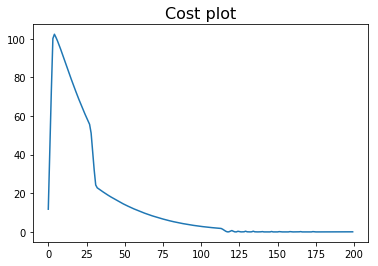

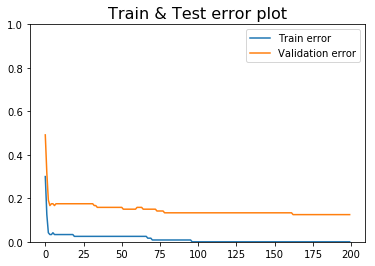


 ****************************** Validation phase *******************************

# ( 4 / 4 ) hsp candidate : (0.4, 0.4) #
< Epoch 50 > Cost : 0.0234 / Train err : 0.0083 /  Validation  err : 0.1417
             beta : [0. 0.] / hsp : [0.42651298 0.42672352]
< Epoch 100 > Cost : 0.0083 / Train err : 0.0000 /  Validation  err : 0.1417
             beta : [0. 0.] / hsp : [0.42467998 0.42667891]
< Epoch 150 > Cost : 0.0079 / Train err : 0.0000 /  Validation  err : 0.1417
             beta : [0. 0.] / hsp : [0.42421513 0.42656564]
< Epoch 200 > Cost : 0.0078 / Train err : 0.0000 /  Validation  err : 0.1417
             beta : [0. 0.] / hsp : [0.42404843 0.42652379]



-> Accuracy : 0.858


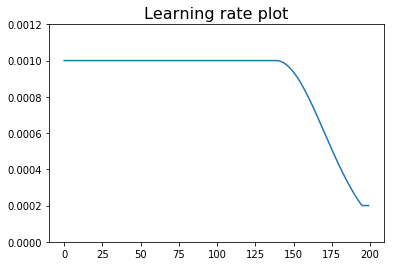

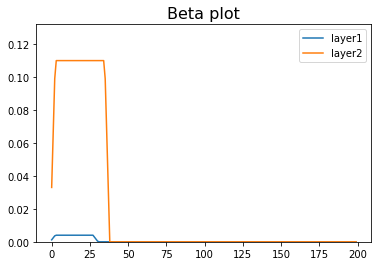

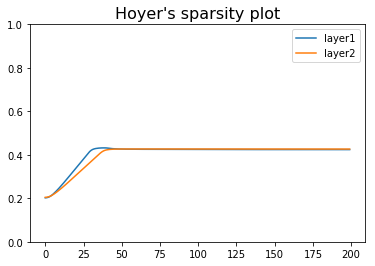

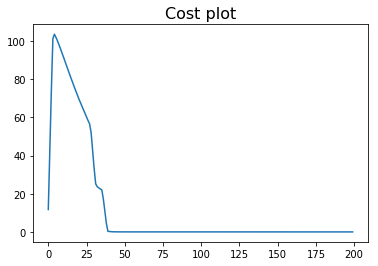

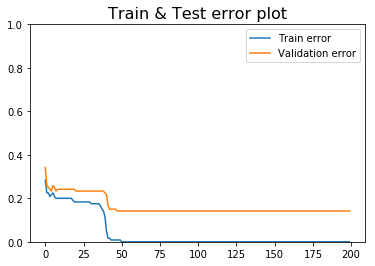


 ****************************** Test phase *******************************

#################################################################
############### ==> Selected hsp : (0.8, 0.4) ###############
#################################################################
< Epoch 50 > Cost : 2.5821 / Train err : 0.0000 /  Test  err : 0.0500
             beta : [0.004 0.   ] / hsp : [0.7908812 0.4203418]
< Epoch 100 > Cost : 0.0441 / Train err : 0.0000 /  Test  err : 0.0333
             beta : [0. 0.] / hsp : [0.80099534 0.41777295]
< Epoch 150 > Cost : 0.0055 / Train err : 0.0000 /  Test  err : 0.0083
             beta : [0. 0.] / hsp : [0.80127062 0.41734041]
< Epoch 200 > Cost : 0.0432 / Train err : 0.0000 /  Test  err : 0.0167
             beta : [0. 0.] / hsp : [0.80036357 0.41718117]



-> Accuracy : 0.983


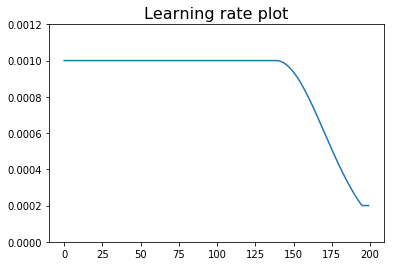

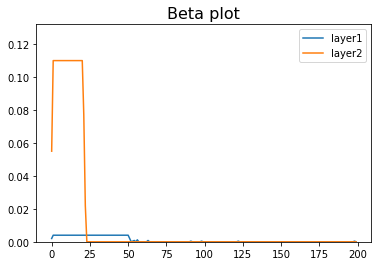

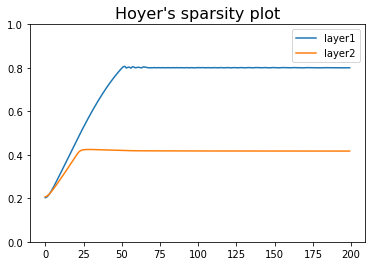

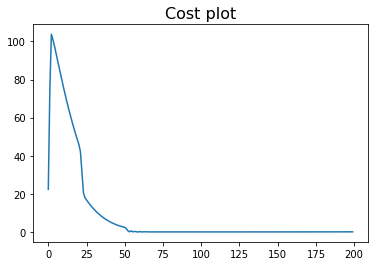

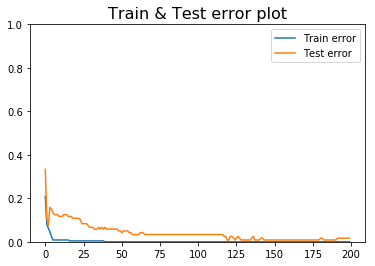


####################################################################


==> Training has been finished!

The code ran for 12 mins




In [20]:
start_time = timeit.default_timer()



error_vd = [None]*n_hsp_cands
hsp_vd = [None]*n_hsp_cands

for i_tg in range(n_hsp_cands+1):
    
        
    ### (1) In case of a validation phase 
    if i_tg < n_hsp_cands:      
        vd_ts = 'Validation'
        # One of candidates
        hsp_tg = hsp_cands[i_tg]
        n_hsp_tg = len(hsp_tg)
        
        # One subject from train data as inner training set
        train_x_set = train_x[:int(np.size(train_x,axis=0)/2)][:]
        train_y_set = train_y[:int(np.size(train_y,axis=0)/2)][:]
        # The other subject from train data as inner validation set
        test_x_set = train_x[int(np.size(train_x,axis=0)/2):][:]
        test_y_set = train_y[int(np.size(train_y,axis=0)/2):][:]
        print("\n ****************************** Validation phase *******************************\n")
        print("# (",i_tg+1,"/",n_hsp_cands,") hsp candidate :",hsp_tg,"#")
        
    ### (2) In case of a test phase
    else:
        vd_ts = 'Test'
        # To set a target as an optimal sparsity level
        i_selected = np.argmin(error_vd)      
        hsp_tg = hsp_cands[i_selected]
        n_hsp_tg = len(hsp_tg) 

        train_x_set = train_x[:][:]
        train_y_set = train_y[:][:]
        test_x_set = test_x[:][:]
        test_y_set = test_y[:][:]
        print("\n ****************************** Test phase *******************************\n")
        print("#################################################################")
        print("############### ==> Selected hsp :",hsp_tg,"###############")
        print("#################################################################")

        
        
    # Training starts    
    with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:
               
        
        # Make a new results directory for the target
        hsp_tg_str=['0.%02d-'%(i*100) for i in hsp_tg]
        hsp_tg_str[-1]=hsp_tg_str[-1][:-1]
        hsp_tg_str=''.join(hsp_tg_str)

        directory_results = os.path.join(directory_save, r'%s_hsp_tg_%s'%(vd_ts,hsp_tg_str))
        if not os.path.exists(directory_results):
            os.makedirs(directory_results)
        
        
        # Initialize the variables for saving the results
        beta_val, beta_vec, hsp_val, result_beta, result_hsp, result_lr, result_cost, result_train_err, result_test_err = init_savingVariables(mode, n_hsp_tg)

        # Saver allows us to save and restore the Tensorflow model
        saver = tf.train.Saver()
        if os.path.exists(directory_results+'/saved_model.meta'):
            saver.restore(sess, directory_results+'/saved_model.ckpt')

        # To initialize all the variables in a TensorFlow program, you must explicitly call a special operation
        init = tf.global_variables_initializer()
        sess.run(init)


        # Start training
        for epoch in range(n_epochs):

            # Shuffle training data at the begining of each epoch
            n_samples = np.size(train_x_set, axis=0)
            shuff_ids = np.arange(n_samples)
            np.random.shuffle(shuff_ids)


            # Begin annealing
            if epoch == 0:
                lr = lr_init
            elif decay_rate!=0 and (epoch+1)>begin_anneal:
                lr = max( lr_min, (-decay_rate*(epoch+1) + (1+decay_rate*begin_anneal)) * lr )


            
            cost_epoch=0.0
            
            # How many mini-batch iterations we need
            n_batches = int(np.ceil(n_samples/batch_size))
            
            # minibatch based training
            for batch in range(n_batches):
                first_sample = batch*batch_size
                last_sample = min((batch+1)*batch_size, n_samples)
                batch_x = train_x_set[shuff_ids[first_sample:last_sample]]
                batch_y = train_y_set[shuff_ids[first_sample:last_sample]]
  
                # Get cost and optimize the model
                cost_batch,_ = sess.run([cost,optimizer],{Lr:lr, X:batch_x, Y:batch_y, Beta:beta_vec, L2_REG:L2_reg})
                cost_epoch += cost_batch/n_batches

                # Weight sparsity control
                if mode=='layer':
                    for i in range(n_hsp_tg):
                        [hsp_val[i], beta_val[i]] = Hoyers_sparsity_control(mode, beta_lr[i], sess.run(w[i]), beta_val[i], max_beta[i], hsp_tg[i])
                    beta_vec = beta_val[:]

                elif mode=='node':
                    for i in range(n_hsp_tg):
                        [hsp_val[i], beta_val[i]] = Hoyers_sparsity_control(mode, beta_lr[i], sess.run(w[i]), beta_val[i], max_beta[i], hsp_tg[i])
                    # flatten beta_val (shape (3, 100) -> (300,))
                    beta_vec = [item for sublist in beta_val for item in sublist]

            # get train and test error
            train_err_epoch = sess.run(error,{X:train_x_set, Y:train_y_set}) 
            test_err_epoch = sess.run(error,{X:test_x_set, Y:test_y_set})
            

            # Save the results to array
            result_train_err = np.hstack([result_train_err,[train_err_epoch]])
            result_test_err = np.hstack([result_test_err,[test_err_epoch]])
            result_lr = np.hstack([result_lr,[lr]])
            result_cost = np.hstack([result_cost,[cost_epoch]])

            if mode=='layer':
                result_hsp=[np.vstack([result_hsp[i],[hsp_val[i]]]) for i in range(n_hsp_tg)]
                result_beta=[np.vstack([result_beta[i],[beta_val[i]]]) for i in range(n_hsp_tg)]

            elif mode=='node':
                result_hsp=[np.vstack([result_hsp[i],[np.transpose(hsp_val[i])]]) for i in range(n_hsp_tg)]
                result_beta=[np.vstack([result_beta[i],[np.transpose(beta_val[i])]]) for i in range(n_hsp_tg)]
                
            # Save the trained model every 50 step
            saver.save(sess, directory_results+'/saved_model.ckpt', global_step=50)

            # Print result at epoch 
            if ((epoch+1)%50==0):             
                print("< Epoch", "{:02d}".format(epoch+1),"> Cost :", "{:.4f}".format(cost_epoch)\
                                                ,"/ Train err :", "{:.4f}".format(train_err_epoch),"/ ",vd_ts," err :","{:.4f}".format(test_err_epoch))
                print("             beta :",np.mean(np.swapaxes(result_beta,0,1)[-1],axis=1),"/ hsp :",np.mean(np.swapaxes(result_hsp,0,1)[-1],axis=1))

                
                
                
                
                
        print("\n\n")
        print("-> Accuracy :", "{:.3f}".format(1-result_test_err[-1]))
        
            
        # Plot and save the figures
        # Plot the change of learning rate
        plt.figure()
        plt.title("Learning rate plot",fontsize=16)
        result_lr=result_lr[1:]
        plt.ylim(0.0, lr_init*1.2)
        plt.plot(result_lr)
 
        plt.savefig(directory_results+'/learning_rate.png')
        plt.show();

        if mode=='layer':
            # Plot the change of beta value
            print("")
            plt.figure()
            for i in range(n_hsp_tg):
                print("")
                plt.title("Beta plot",fontsize=16)
                result_beta[i]=result_beta[i][1:]
                plt.plot(result_beta[i], label='layer%d'%(i+1))
                plt.ylim(0.0, np.max(max_beta)*1.2)
            plt.legend(loc='best')
         
            plt.savefig(directory_results+'/beta.png')
            plt.show();

            # Plot the change of Hoyer's sparsity level
            print("")
            plt.figure()
            for i in range(n_hsp_tg):
                print("")
                plt.title("Hoyer's sparsity plot",fontsize=16)
                result_hsp[i]=result_hsp[i][1:]
                plt.plot(result_hsp[i], label='layer%d'%(i+1))
                plt.ylim(0.0, 1.0)
            plt.legend(loc='best')
 
            plt.savefig(''.join([directory_results, '/hsp_final', 
                            ''.join(['_{:.3f}'.format(np.mean(result_hsp[i][-1])) for i in range(n_hsp_tg)]),'.png']))
            plt.show();

        elif mode=='node':
            # Plot the change of beta value
            print("")
            for i in range(n_hsp_tg):
                plt.figure()
                plt.title("Beta plot (layer"+str(i+1)+")",fontsize=16)
                result_beta[i]=result_beta[i][1:]
                plt.plot(result_beta[i])
                plt.ylim(0.0, np.max(max_beta)*1.2)
                
                plt.savefig(directory_results+'/beta_layer'+str(i+1)+'.png')
                plt.show();

            # Plot the change of Hoyer's sparsity level
            print("")         
            for i in range(n_hsp_tg):
                plt.figure()
                plt.title("Hoyer's sparsity plot (layer"+str(i+1)+")",fontsize=16)
                result_hsp[i]=result_hsp[i][1:]
                plt.plot(result_hsp[i])
                plt.ylim(0.0, 1.0)
           
                plt.savefig(''.join([directory_results, '/hsp_layer'+str(i+1)+'_final', 
                                ''.join(['_{:.3f}'.format(np.mean(result_hsp[i][-1])) for i in range(n_hsp_tg)]),'.png']))
                plt.show();
        
        # Plot the change of cost
        plt.figure()
        plt.title("Cost plot",fontsize=16)
        result_cost=result_cost[1:]
        plt.plot(result_cost)
        
        plt.savefig(directory_results+'/cost.png')
        plt.show();


        # Plot train & test error
        plt.figure();
        plt.title("Train & Test error plot",fontsize=16)
        result_train_err=result_train_err[1:]
        plt.plot(result_train_err, label='Train error')
        result_test_err=result_test_err[1:]
        plt.plot(result_test_err, label='%s error'%vd_ts)
        plt.ylim(0.0, 1.0)
        plt.legend(loc='upper right')
        
        plt.savefig(directory_results+'/error_'+"tr{:.4f}_ts{:.4f}".format(result_train_err[-1],result_test_err[-1])+'.png')
        plt.show();
            
            
        # save results as .mat file
        sio.savemat(directory_results+"/result_learningrate.mat", mdict={'lr': result_lr})
        sio.savemat(directory_results+"/result_cost.mat", mdict={'cost': result_cost})
        sio.savemat(directory_results+"/result_train_err.mat", mdict={'trainErr': result_train_err})
        sio.savemat(directory_results+"/result_test_err.mat", mdict={'testErr': result_test_err})
        sio.savemat(directory_results+"/result_beta.mat", mdict={'beta': result_beta})
        sio.savemat(directory_results+"/result_hsp.mat", mdict={'hsp': result_hsp})
        w_val = sess.run(w)
        b_val = sess.run(b)
        sio.savemat(directory_results+"/result_weight.mat", mdict={'weight': w_val})
        sio.savemat(directory_results+"/result_bias.mat", mdict={'bias': b_val})
        
        # If it was validation phase
        if i_tg < n_hsp_cands: 
            plt.close('all')
            error_vd[i_tg] = result_test_err[-1]
            hsp_vd[i_tg] = np.mean(np.swapaxes(result_hsp,0,1)[-1],axis=1)
   
          
        
end_time = timeit.default_timer()

print('\n####################################################################\n\n')
print('==> Training has been finished!\n')
print('The code ran for %d mins' %((end_time-start_time)/60)+'\n\n')

## 2-9. Save parameters and summary as text file

In [0]:
f = open(directory_save+"/parameters_summary.txt",'w') 
f.write('mode : '+str(mode)+'\n')
f.write('optimizer_algorithm : '+str(optimizer_algorithm)+'\n')
f.write('layer_activation : '+str(layer_activation)+'\n')
f.write('n_epochs : '+str(n_epochs)+'\n')
f.write('batch_size : '+str(batch_size)+'\n')
f.write('lr_init : '+str(lr_init)+'\n')
f.write('lr_min : '+str(lr_min)+'\n')
f.write('begin_anneal : '+str(begin_anneal)+'\n')
f.write('decay_rate : '+str(decay_rate)+'\n')
f.write('L2_reg : '+str(L2_reg)+'\n')
f.write('max_beta : '+str(max_beta)+'\n')
f.write('beta_lr : '+str(beta_lr)+'\n')
f.write('---\n')
for i_tg in range(n_hsp_cands):
    f.write('('+str(i_tg+1)+'/'+str(n_hsp_cands)+') tg :'+str(hsp_cands[i_tg])+'/ hsp : '+str(hsp_vd[i_tg])+'- val error : '+"{:.4f}".format(error_vd[i_tg])+'\n')
f.write('==> Selected tg :'+str(hsp_cands[i_selected])+'/ hsp : '+str(np.mean(np.swapaxes(result_hsp,0,1)[-1],axis=1))+'- ts error : '+"{:.4f}".format(result_test_err[-1])+'\n')
f.write('\n The code ran for %d mins' %((end_time-start_time)/60)+'\n\n')
f.close()

## 2-10. Weight feature map interpretation

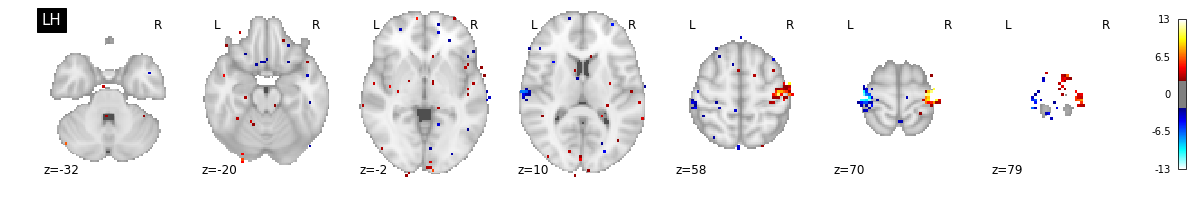

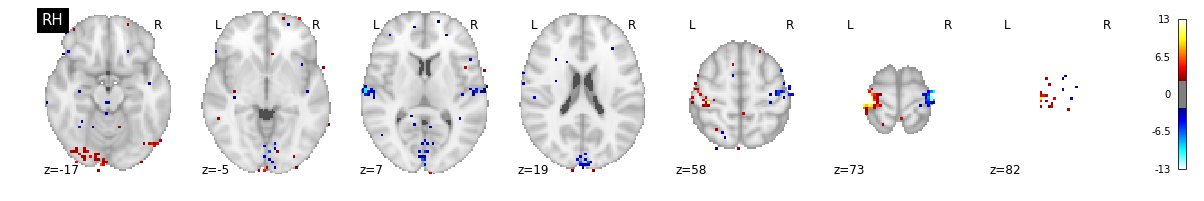

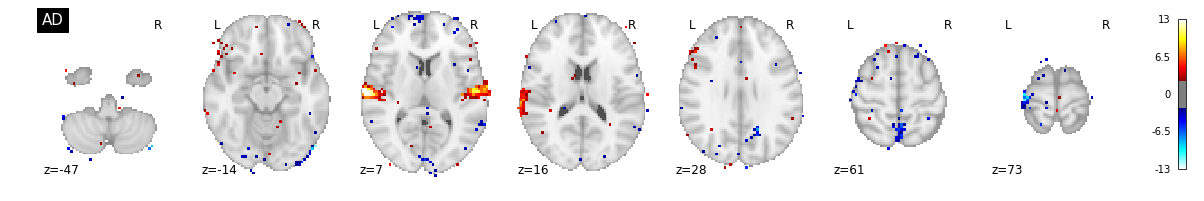

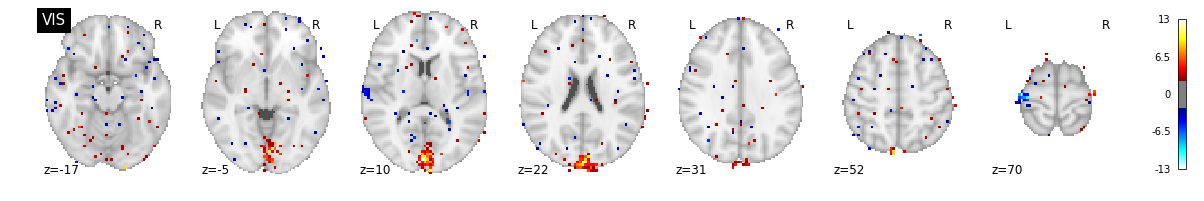

In [22]:
# Installation of Nibable to create a Nifti image from numpy array
!pip install nibabel
print('\n\n')
import nibabel as nib

from functools import reduce
import scipy

# Multiply all the weight parameters upto output layer
wf_map_vecs = reduce(lambda x,y: np.matmul(x,y), w_val)
# z-scoring
wf_map_vecs_z = scipy.stats.zscore(wf_map_vecs,axis=0)

# Saving them as a .mat file
sio.savemat(directory_results+"/result_wf_map_vecs_z.mat", mdict={'wf_map_vecs_z': wf_map_vecs_z})

# Plotting the results
wf_map = [None]*n_tasks
for run in range(n_tasks):
    wf_map[run] = np.zeros((xdim, ydim, zdim))
    wf_map[run][vMsk_3d==1] = wf_map_vecs_z.T[run]
    
    wf_map_plot = nib.Nifti1Image(wf_map[run], vMsk_3d_nii.affine)
    plotting.plot_stat_map(wf_map_plot, display_mode="z", threshold = 2.58, vmax=13, title=tasks[run])


#  
#   

---  

